# **Why Transfer Learning?**

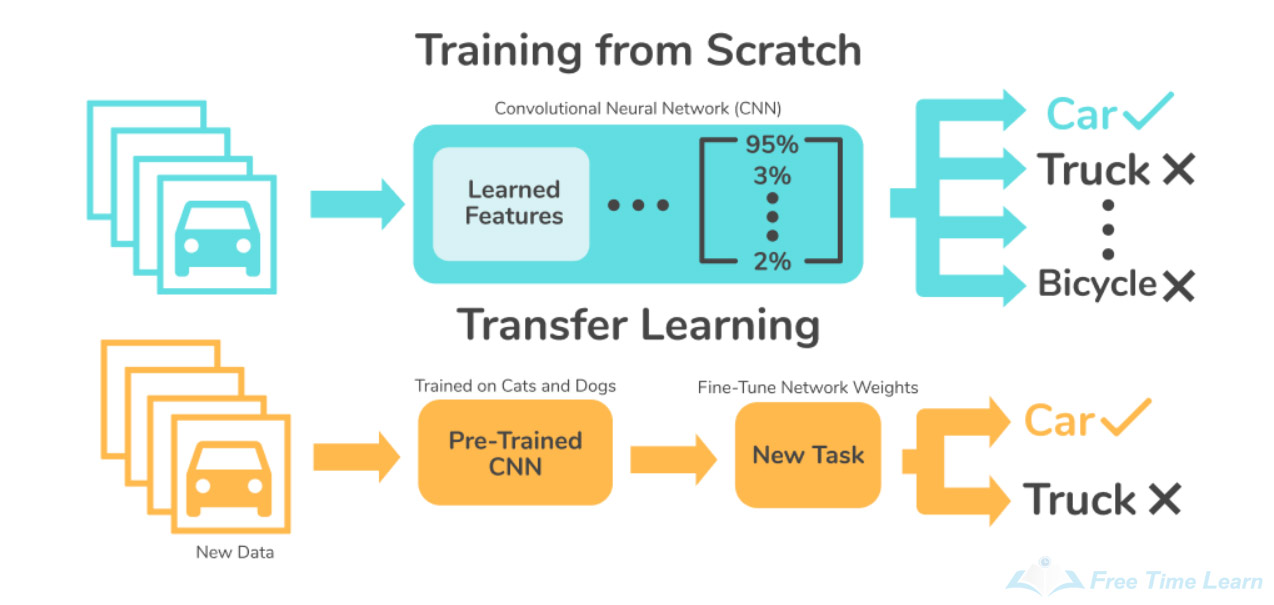

**Transfer learning** is a **powerful technique** in machine learning where a model trained on **one task** is **repurposed or adapted** for use on a **different**, but **related task**. It is particularly useful when you have a **limited amount of data** for the **new task** or when training a **model from scratch** would be **computationally expensive**.

There are two main methods in transfer learning: feature extraction and fine-tuning.

1. **Feature Extraction**: In this method, you take a **pre-trained model** and **remove the final layers** (the output layers) that were originally trained for the specific task it was initially trained on. You then **add new layers** suited to your task on top of the **remaining layers** of the **pre-trained model**.

 These new layers are typically **randomly initialized** and then trained on your **specific dataset**. The earlier layers of the pre-trained model act as **feature extractors**, capturing **general features** from the input data.

 This approach is effective when the **pre-trained model** was **trained on a dataset** that is **similar** in nature to your **new dataset**.

2. **Fine-tuning**: Fine-tuning involves **not only adding new layers** for your specific task but also **continuing the training** of the **entire model** with a **relatively low learning rate** on your new dataset.

 This allows the model to adjust its parameters not only in the **newly added layers** but also in the **existing layers** of the **pre-trained model**.

 Fine-tuning is useful when you have a **larger dataset** for the **new task** and when the task is **quite similar** to the task the **pre-trained model** was originally trained on.

# **Environmental SetUp**

Let's first gather all the **required libraries** that will be used throughout this notebook. We will also set up **some constants** those will be usefull.

In [1]:
# Main Libraries
import os
import tensorflow as tf
from tensorflow import keras

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Neural Networks
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

2024-03-27 21:40:34.300870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 21:40:34.300962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 21:40:34.429139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Data Configs
IMAGE_SIZE = (160, 160)
TRAIN_DIR = "/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Train"
VALID_DIR = "/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Valid"
TEST_DIR = "/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Test"
BATCH_SIZE = 32

# Reproducibility
SEED = 42

In [3]:
# Set the random state
tf.random.set_seed(SEED)

# **Data Loading & Processing**

The data is present in a single directory. So we can use the tensorflow's utility function to load the data set.

In [4]:
# Define Generators
train_gen = keras.preprocessing.image.ImageDataGenerator()
train_ds = train_gen.flow_from_directory(
    TRAIN_DIR, 
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 15000 images belonging to 10 classes.


In [5]:
# Load the validation dataset
valid_ds = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

# Load the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 3500 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.


Let's collect some more information about the data, which will be useful later on.

In [6]:
# Collect class names
class_names = sorted(os.listdir(TRAIN_DIR))
n_classes = len(class_names)

# Compute class distribution
class_dis = [len(os.listdir(TRAIN_DIR + f"/{name}")) for name in class_names]

# Class Distribution Visualization
bar_plot = px.bar(x=class_names, y=class_dis, title="Class Distribution")
bar_plot.update_layout(xaxis_title="Class Names", yaxis_title="Frequency")
bar_plot.show()

The positive aspect is that our dataset exhibits **perfect class balance**, with an **equal number of samples for each class**. This scenario highlights the **critical importance of leveraging transfer learning techniques**. With such a small dataset, attempting to **train a model from scratch** would likely yield **suboptimal results**. **Transfer learning** enables us to maximize the **utility of the available data** by leveraging knowledge from **pre-trained models**, thereby enhancing our ability to address the **classification task effectively**.

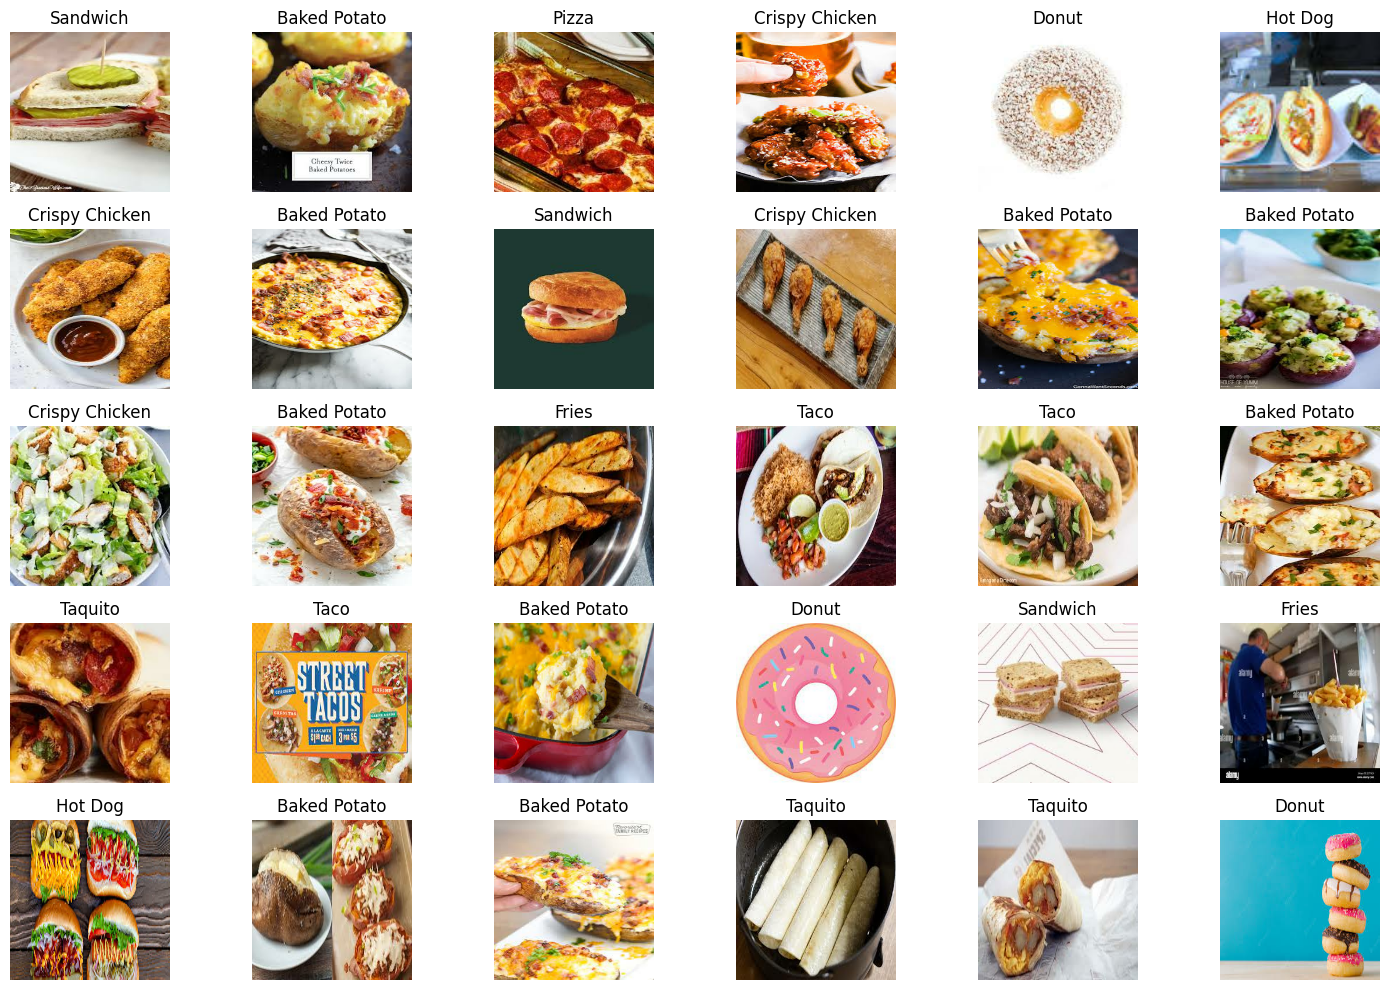

In [7]:
# Visualizing sample points
plt.figure(figsize=(15, 10))
for images, labels in valid_ds.take(1):
    for i in range(1, 31):
        plt.subplot(5, 6, i)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[int(labels[i])])
plt.tight_layout()
plt.show()

# **Data Augmentation**

**Transfer learning** proves **invaluable** for training models efficiently without starting from scratch, especially when working with **limited data**. **Augmenting** the dataset further enhances the **model's robustness and generalization capabilities**, making it adept at handling **diverse scenarios** and **variations within the data**.

In [8]:
data_augmenter = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomRotation(0.2),
    layers.RandomFlip('horizontal_and_vertical')
], name="DataAugmenter")

Let's see the data augmentation in action.

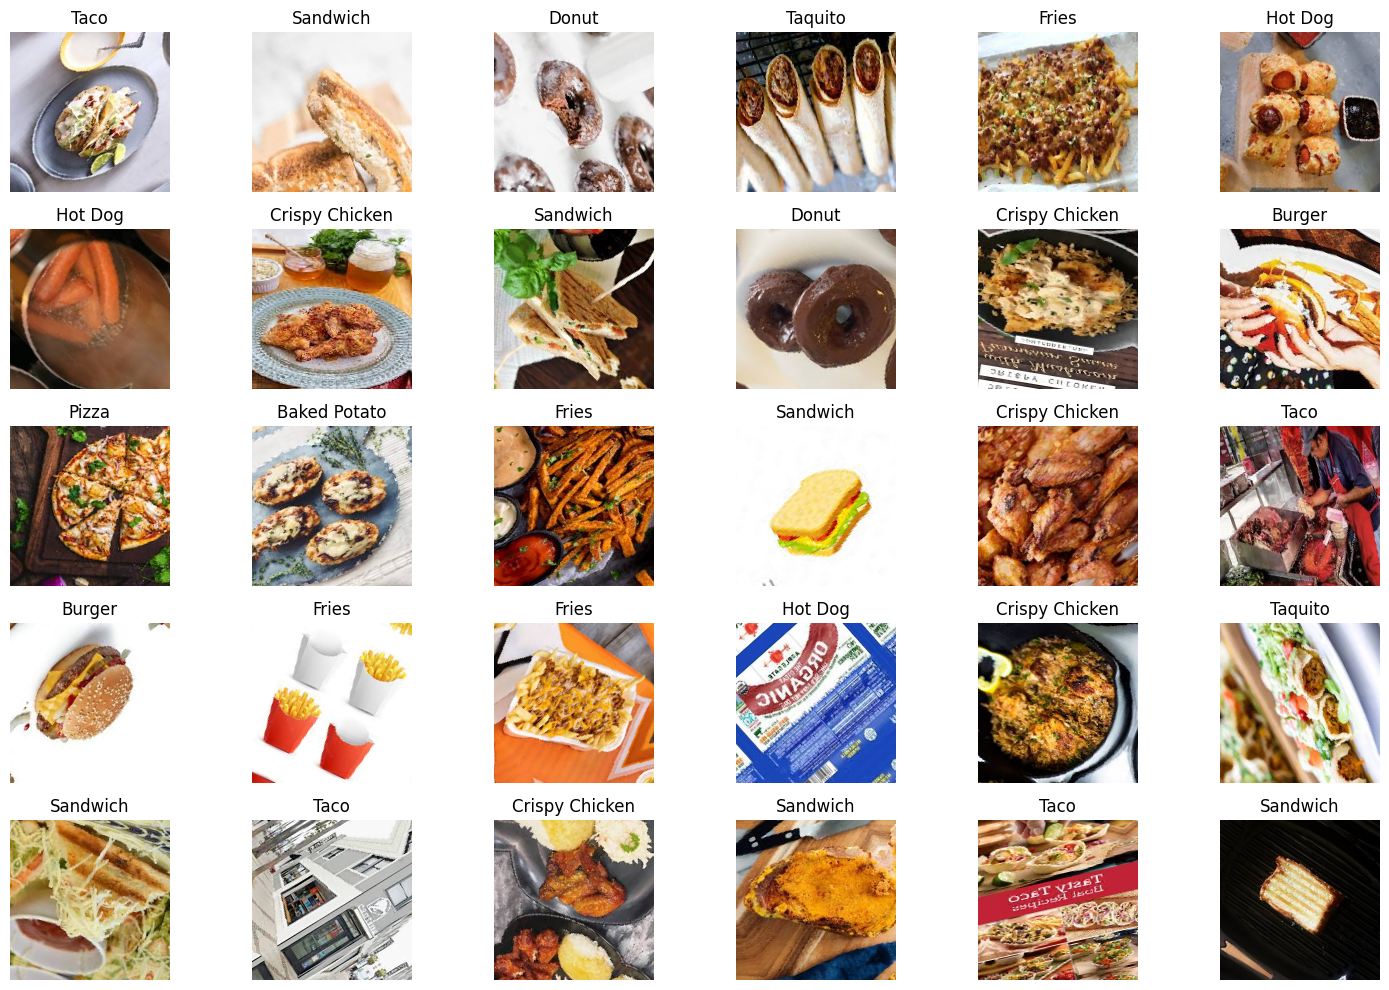

In [9]:
# Collect images & labels
images, labels = next(iter(train_ds))

# Apply data augmentation
aug_images = data_augmenter(images)

# Visualizing sample points
plt.figure(figsize=(15, 10))
for i in range(1, 31):
    plt.subplot(5, 6, i)
    plt.imshow(aug_images[i])
    plt.axis('off')
    plt.title(class_names[int(labels[i])])
plt.tight_layout()
plt.show()

The visualization clearly demonstrates the impact of *random rotation* and *flipping* on the dataset. Notably, we no longer need to convert the data type to `uint8`, as indicated by *the rescaling layer's effect.*

Both applying **data augmentation** directly on the **dataset** and incorporating it within the **model architecture** are **valid approaches**. In this instance, we'll opt to embed the **augmentation step** directly into the **model architecture**, ensuring **seamless integration and simplifying the overall workflow.**

# **Feature Extraction**

As mentioned earlier, **transfer learning** can be executed through **two distinct methods**: `feature extraction` and `fine-tuning`. We'll start by examining how `feature extraction` performs with our current dataset.

In [10]:
# Loading the base model
base_model = keras.applications.MobileNet(input_shape=(*IMAGE_SIZE, 3), include_top=False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


When utilizing the **base model** as a `feature extractor`, training the model **isn't** necessary. Therefore, we'll **freeze the layers** of the **base model** for this purpose.

In [11]:
# Freeze the base model
base_model.trainable = False

In [12]:
# # Run if needed
# base_model.summary()

Given the **substantial size** of this **model architecture**, it's reasonable to anticipate that it has **already assimilated a vast amount of knowledge**. `MobileNet`, renowned for its **speed and accuracy**, holds promise for our task. With its **established capabilities**, we have **optimistic expectations** for its **effectiveness in our context.**

In [13]:
# Model architecture
model = keras.Sequential([
    layers.Input(shape=(*IMAGE_SIZE, 3)),
    data_augmenter,                                            # For Data Augmentation
    base_model,                                                # For Feature Extraction
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.GlobalAveragePooling2D(),
    layers.Dense(n_classes, activation='softmax', kernel_regularizer="l2")
], name="FeatureExtractor")

# Model Summary
model.summary()

Model: "FeatureExtractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ DataAugmenter (Sequential)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_160 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 5, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,243,210 (12.37 MB)

 Trainable params: 12,298 (48.04 KB)

 Non-trainable params: 3,230,912 (12.32 MB)

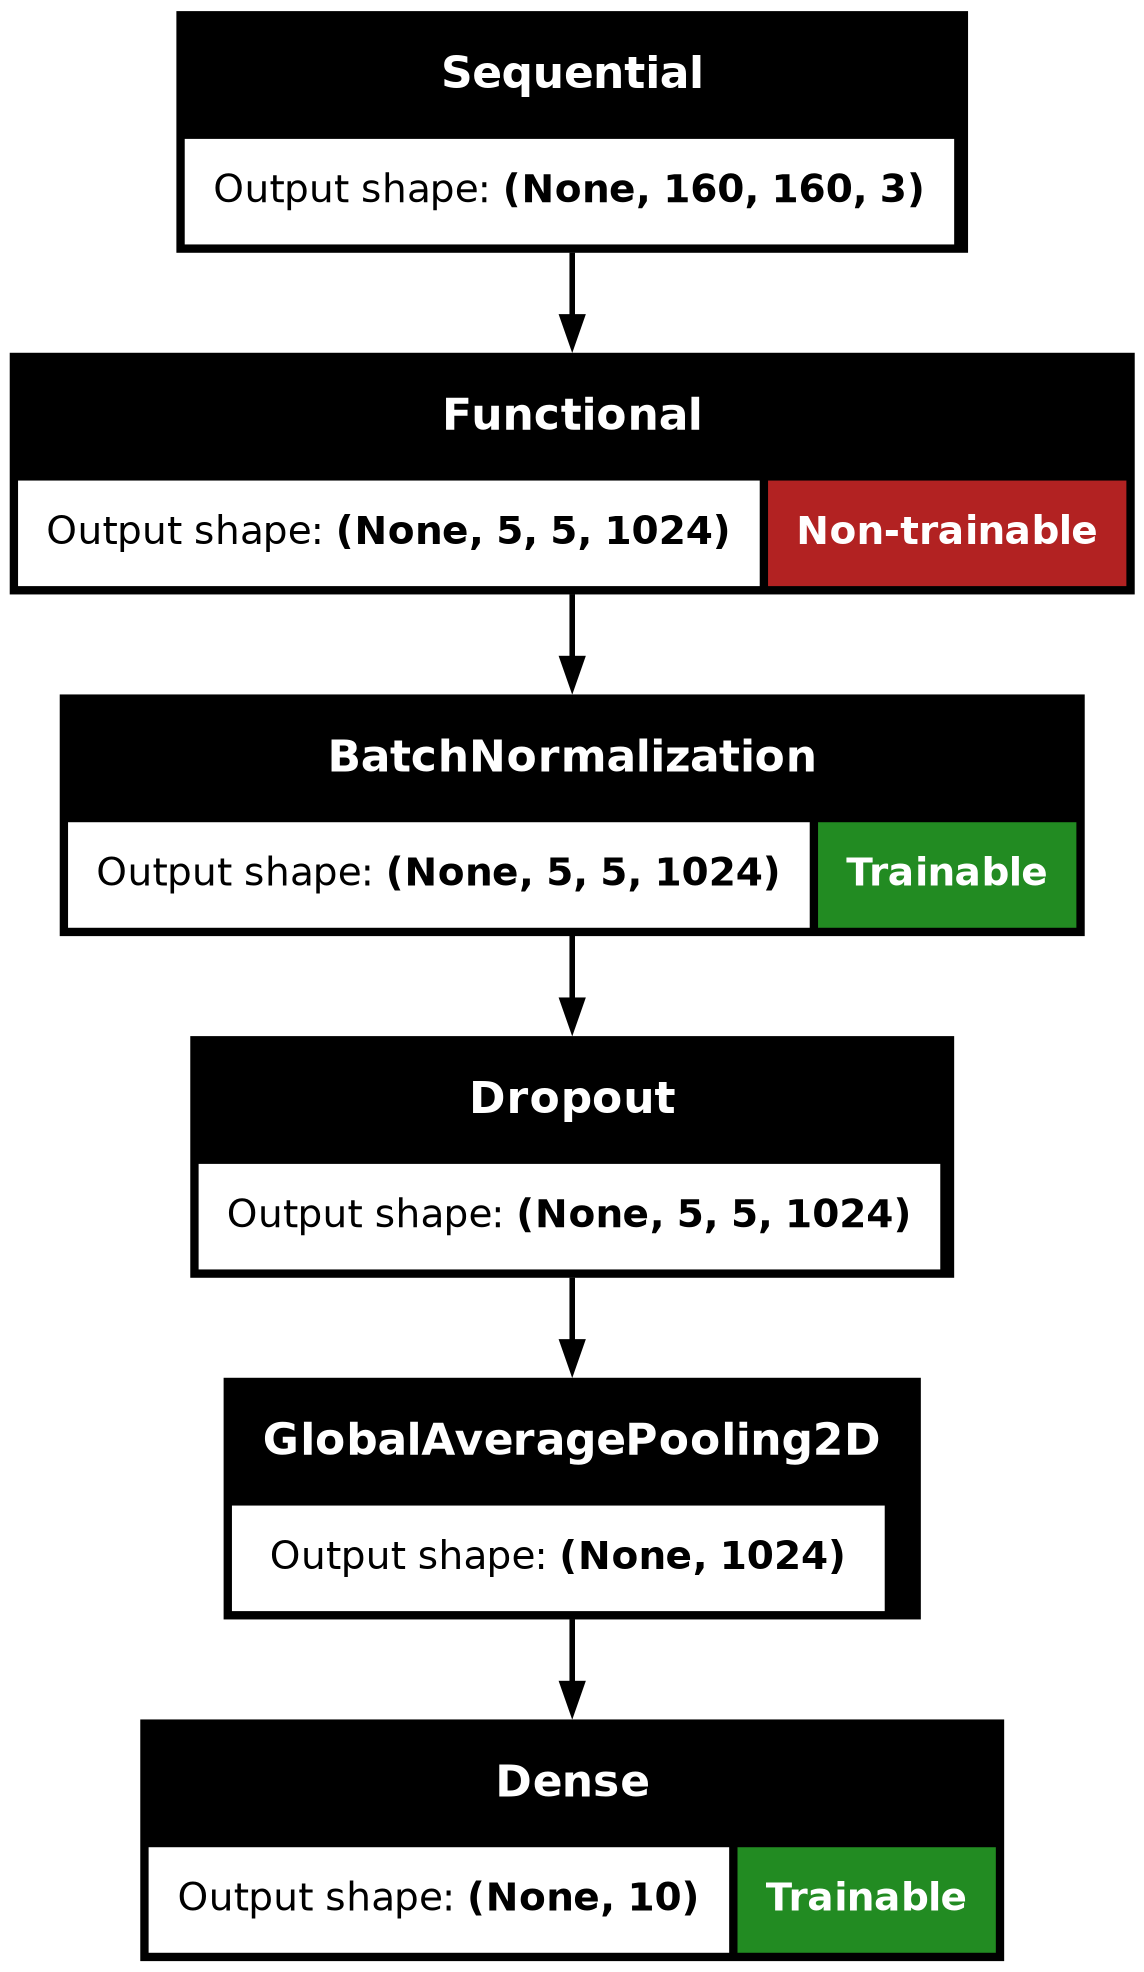

In [14]:
# Model Visualization
keras.utils.plot_model(
    model, 
    to_file="FeatureExtractor.png", 
    show_shapes=True, show_trainable=True
)

As evident, our base model, `MobileNet`, remains **non-trainable** as it functions solely as a **feature extractor**. The **only trainable layer** within our model is the **final dense layer**, serving as the **top classifier**.

In [15]:
# Model Compilation
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# Model Training
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 131ms/step - accuracy: 0.5051 - loss: 1.6836 - val_accuracy: 0.7177 - val_loss: 1.0713
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - accuracy: 0.7218 - loss: 1.0657 - val_accuracy: 0.7374 - val_loss: 1.0060
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.7373 - loss: 1.0085 - val_accuracy: 0.7397 - val_loss: 0.9868
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.7387 - loss: 0.9940 - val_accuracy: 0.7394 - val_loss: 0.9753
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - accuracy: 0.7348 - loss: 0.9876 - val_accuracy: 0.7346 - val_loss: 0.9911
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - accuracy: 0.7355 - loss: 0.9785 - val_accuracy: 0.7366 - val_loss: 0.9880
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.7481 - loss: 0.9645 - val_accuracy: 0.7317 - val_loss: 0.9918


The effectiveness of using the MobileNet model as a feature extractor is apparent in the results. By leveraging transfer learning, we achieved an impressive accuracy of 74%, surpassing what could be attained by training a model from scratch.

In [16]:
# Visualize the Learning Curve
loss_curve = px.line(
    history.history, y=["loss", "val_loss"], 
    labels={
        "value":"Loss Value",
        "index":"Epochs",
        "variable":"Categorical Crossentropy"
    },
    title="Learning Loss Curve"
)
loss_curve.show()

acc_curve = px.line(
    history.history, y=["accuracy", "val_accuracy"], 
    labels={
        "value":"Accuracy",
        "index":"Epochs",
        "variable":"Accuracy"
    },
    title="Learning Accuracy Curve"
)
acc_curve.show()

Indeed, the potential of **transfer learning** shines through as we leverage the `MobileNet` architecture solely as a **feature extractor**. Achieving an **74% accuracy** on the **training data** and approximately **73% accuracy** on the **validation data** marks a **significant accomplishment**. However, it's evident that **our models exhibit overfitting tendencies**. 

This discrepancy underscores the fact that we've **only trained a single layer within our model**, emphasizing the **fascinating capability** of **transfer learning**. Despite this challenge, the essence of **transfer learning** remains clear—it empowers us to **leverage pre-trained architectures effectively**, laying a **strong foundation** for **further refinement and improvement.**

# **Fine Tuning**

To enhance our **model's performance**, our goal is twofold: to **mitigate overfitting** while pushing the **accuracy beyond 95%.** While we'll continue to **leverage transfer learning**, this time we'll employ **fine-tuning to achieve these objectives.**

In [17]:
# Unfreeze all layers
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
        
# Get the list of trainable variables
trainable_variables = len(base_model.trainable_variables)

# Print the number of trainable layers
print("Number of trainable layers: ", trainable_variables)

Number of layers in the base model:  86
Number of trainable layers:  35


Initially, we **unfreeze all layers** of the model, but subsequently **freeze all layers except for the top 50**. This decision is strategic: **lower-level features** are **typically common across tasks** and should **remain unchanged**, while **higher-level features contribute more significantly** to differentiation. **Unfreezing** the **top layers** allows us to **fine-tune** these crucial **higher-level features**, optimizing our model for **improved performance**.

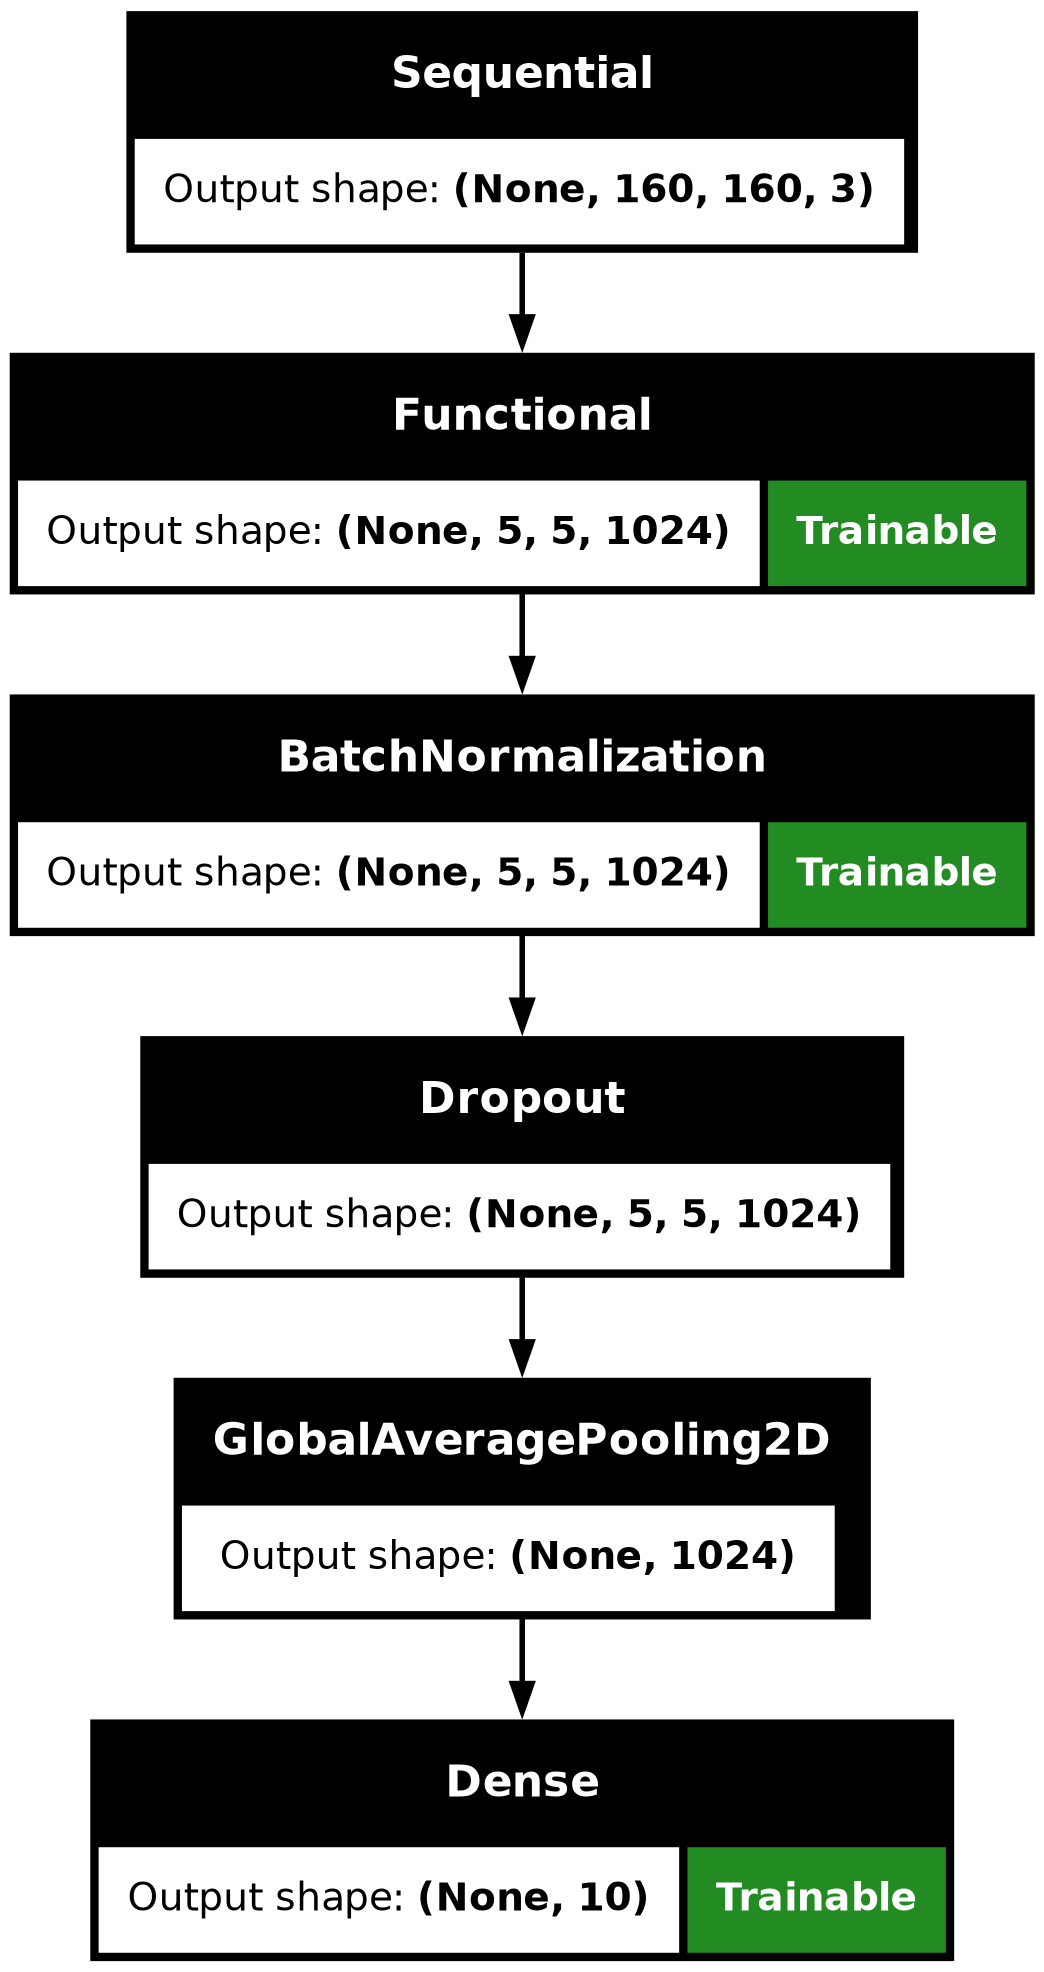

In [18]:
# Model Visualization
keras.utils.plot_model(
    model, 
    to_file="FineTuning.png", 
    show_shapes=True, show_trainable=True
)

In [19]:
# Model Compilation
model.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Model Training
history_ = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    initial_epoch=history.epoch[-1],
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 7/100


2024-03-27 21:49:15.534426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/FeatureExtractor_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 60/469 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.7198 - loss: 1.0599

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.7430 - loss: 0.9590 - val_accuracy: 0.7657 - val_loss: 0.9204
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.8201 - loss: 0.7143 - val_accuracy: 0.7923 - val_loss: 0.8253
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.8465 - loss: 0.6224 - val_accuracy: 0.8166 - val_loss: 0.7264
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.8603 - loss: 0.5661 - val_accuracy: 0.8157 - val_loss: 0.7246
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.8807 - loss: 0.5033 - val_accuracy: 0.8134 - val_loss: 0.7365
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.8881 - loss: 0.4678 - val_accuracy: 0.8309 - val_loss: 0.6633
Epoch 13/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.8976 - loss: 0.4249 - val_accuracy: 0.8374 - val_loss: 0.6465
Epoch 14/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.9073 - loss: 0.3932 -

In [20]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Testing Loss: {test_loss}")
print(f"Testing Acc : {test_acc}")

Testing Loss: 0.5805684328079224
Testing Acc : 0.8500000238418579


This is for the very first time that I have seen any model achieveing 85% test accuracy on this dataset.

In [21]:
# Visualize the Learning Curve
loss_curve = px.line(
    history_.history, y=["loss", "val_loss"], 
    labels={
        "value":"Loss Value",
        "index":"Epochs",
        "variable":"Categorical Crossentropy"
    },
    title="Learning Loss Curve"
)
loss_curve.show()

acc_curve = px.line(
    history_.history, y=["accuracy", "val_accuracy"], 
    labels={
        "value":"Accuracy",
        "index":"Epochs",
        "variable":"Accuracy"
    },
    title="Learning Accuracy Curve"
)
acc_curve.show()

The analysis of the accuracy and loss curves clearly indicates overfitting, with a notable gap of almost 10% between the training, validation, and testing accuracies. While the training accuracy reaches an impressive 95%, the testing accuracy remains at 85%, which is the highest achieved by the models thus far.

This notebook primarily aimed to explore the mechanics of transfer learning, specifically focusing on feature extraction and fine-tuning. The results unequivocally demonstrate the effectiveness of transfer learning, showcasing the significant impact it has on model performance.

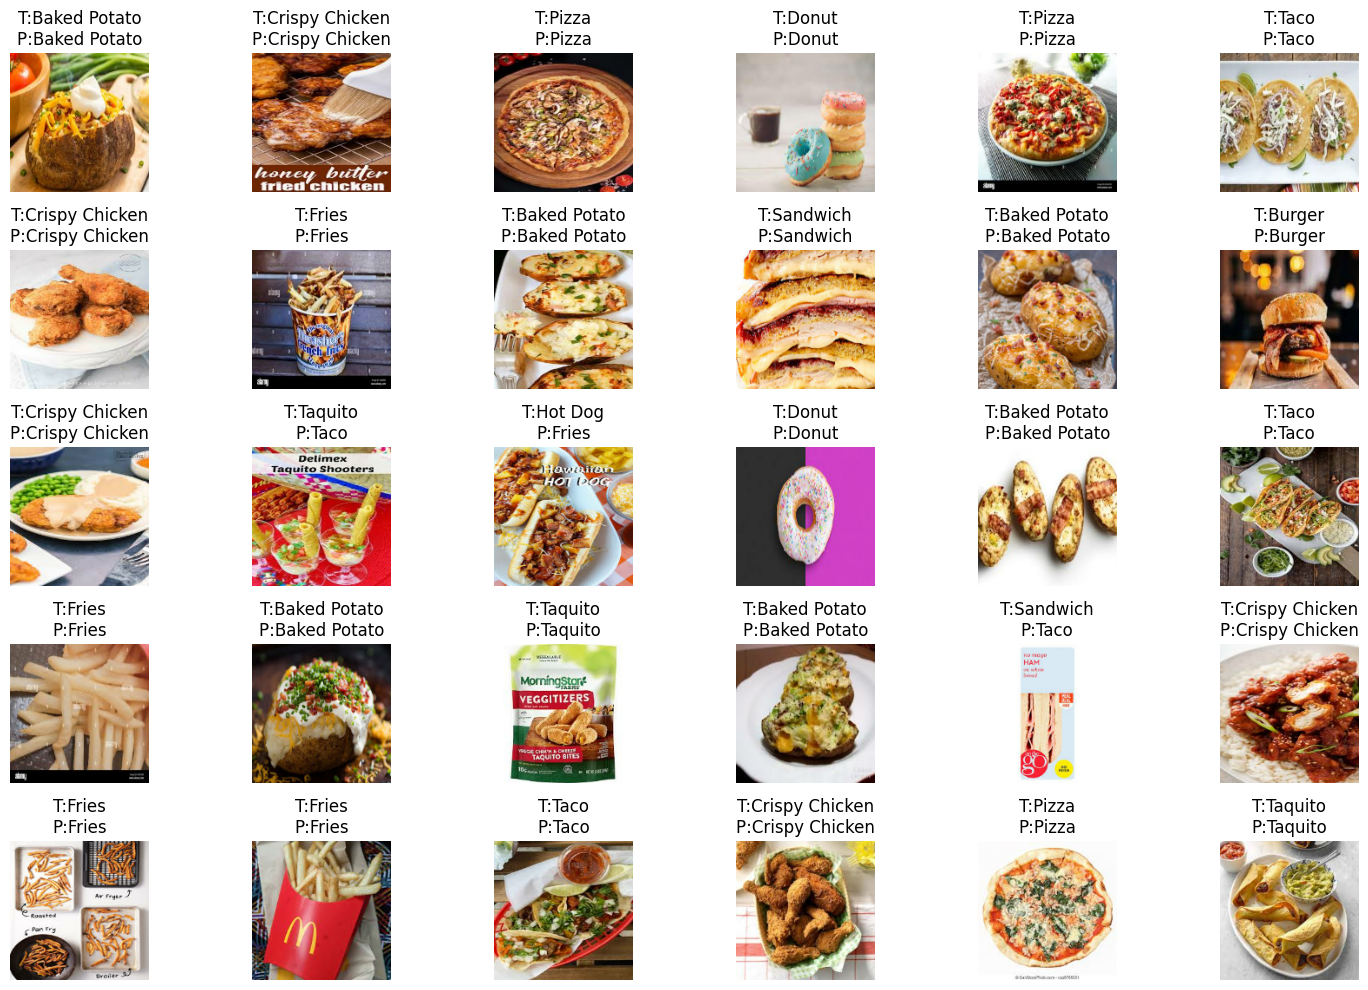

In [22]:
# Collect images & labels
images, labels = next(iter(valid_ds))
preds = tf.argmax(
    model.predict(images, verbose=0),
    axis=-1
)

# Visualizing sample points
plt.figure(figsize=(15, 10))
for i in range(1, 31):
    
    # Decode predictions
    true_label = class_names[int(labels[i])]
    pred_label = class_names[preds[i]]
    
    # Plot image and predictions
    plt.subplot(5, 6, i)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis('off')
    plt.title(f"T:{true_label}\nP:{pred_label}")
    
plt.tight_layout()
plt.show()

Examining the model predictions reveals minimal errors, indicating the high quality of this particular model. Indeed, based on the results observed thus far, this model stands out as one of the most effective and accurate ones developed.

In [23]:
# Saving the model
model.save("FineTuned-MobileNet.keras")

---

**DeepNets**